In [1]:
pip install numpy pandas scikit-learn joblib seaborn matplotlib xgboost imblearn shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

# 1. Business Problem Identification

### Cohere Pets’ Data Science team aims to optimize the process of prior authorization approvals by leveraging historical data to automate decisions.
### Manual authorization processes are slow and can affect customer satisfaction. A predictive model for auto-approving requests could streamline workflows and improve efficiency in the approval pipeline.


# 2. Data Loading and Merging, Cleaning

In [3]:
def load_and_merge_data():
    # Load datasets
    prior_auth = pd.read_excel("DS Case Study.xlsx", sheet_name = 'PriorAuth') 
    claims = pd.read_excel("DS Case Study.xlsx", sheet_name = 'Claims') 

    
    # Merge datasets on pet_id
    data = prior_auth.merge(claims, how="left", left_on="pet_id", right_on="Pet Id")
    
    # Extract day and hour features
    data['submission_day_of_week'] = data['submission_date'].dt.dayofweek
    data['submission_hour_of_day'] = data['submission_date'].dt.hour
    data['claim_day_of_week'] = data['Claim Date'].dt.dayofweek
    data['claim_hour_of_day'] = data['Claim Date'].dt.hour
    
    # Handle missing values
    # Replace null values based on column type
    for column in data.columns:
        if data[column].isnull().sum() > 0:  # Check if column contains null values
            if pd.api.types.is_numeric_dtype(data[column]):
                # Replace null values with median for numeric columns
                median_value = data[column].median()
                data[column].fillna(median_value, inplace=True)
            elif pd.api.types.is_categorical_dtype(data[column]) or data[column].dtype == 'object':
                # Replace null values with mode for categorical columns
                mode_value = data[column].mode()[0]  # mode()[0] returns the most frequent value
                data[column].fillna(mode_value, inplace=True)
            elif pd.api.types.is_datetime64_any_dtype(data[column]):
                # Replace null values with mode for date columns
                mode_date = data[column].mode()[0]
                data[column].fillna(mode_date, inplace=True)

    # Outlier removal using IQR method
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter out outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
        
    return data

In [4]:
data = load_and_merge_data()
print("Data Loaded and Merged Successfully \n")
print("Data understanding:")
data.info()
print("\nFirst few rows of data:\n", data.head())

Data Loaded and Merged Successfully 

Data understanding:
<class 'pandas.core.frame.DataFrame'>
Index: 8824 entries, 0 to 10160
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      8824 non-null   object        
 1   pet_name                8824 non-null   object        
 2   service                 8824 non-null   object        
 3   submission_date         8824 non-null   datetime64[ns]
 4   provider_id             8824 non-null   int64         
 5   unit                    8824 non-null   int64         
 6   authstatus              8824 non-null   object        
 7   auto_approved           8824 non-null   bool          
 8   clinical_reviewer       8824 non-null   object        
 9   pet_id                  8824 non-null   object        
 10  Pet_Name                8824 non-null   object        
 11  Provider NPI            8824 non-null   float64       

/tmp/ipykernel_1442/400264022.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data[column]) or data[column].dtype == 'object':
/tmp/ipykernel_1442/400264022.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(mode_value, inplace=True)
/tmp/ipykernel_1442/400264022.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chaine

In [5]:
data.isnull().sum()

id                        0
pet_name                  0
service                   0
submission_date           0
provider_id               0
unit                      0
authstatus                0
auto_approved             0
clinical_reviewer         0
pet_id                    0
Pet_Name                  0
Provider NPI              0
Claim ID                  0
Claim Type                0
Amount Paid               0
Pet Id                    0
Claim Date                0
submission_day_of_week    0
submission_hour_of_day    0
claim_day_of_week         0
claim_hour_of_day         0
dtype: int64

# 3. Data preprocessing

In [6]:
def preprocess_data(data):
    # Remove unnecessary columns which are ID's
    drop_column_list = ['id', 'submission_date', 'Claim Date', 'pet_name', 
                        'clinical_reviewer', 'pet_id', 'Pet_Name', 
                        'Provider NPI', 'Claim ID', 'Pet Id']
    
    # Check if any of the columns to drop exist in the DataFrame
    columns_to_drop = set(drop_column_list).intersection(data.columns)
    
    if columns_to_drop:
        data = data.drop(columns=columns_to_drop)  # Drop only the existing columns
    
    print(data.columns) 

    # Encode categorical variables
    label_encoders = {}
    categorical_df = data.select_dtypes(include=['object'])
    
    for col in categorical_df:
        le = LabelEncoder()
        # Replace NaN with the mode of the column
        mode_value = data[col].mode()[0]
        data[col] = le.fit_transform(data[col].fillna(mode_value))
        label_encoders[col] = le

    # Convert the target variable to numeric
    data['auto_approved'] = data['auto_approved'].map({True: 1, False: 0})
    
    # Target and feature separation
    target = 'auto_approved'
    X = data.drop(columns=[target])
    y = data[target]
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    return X_res, y_res, label_encoders

In [7]:
X_res, y_res, label_encoders = preprocess_data(data)
print("\n Data Preprocessing Completed \n")
print("X_res \n")
print(X_res)
print ("y_res \n")
print(y_res)

Index(['service', 'provider_id', 'unit', 'authstatus', 'auto_approved',
       'Claim Type', 'Amount Paid', 'submission_day_of_week',
       'submission_hour_of_day', 'claim_day_of_week', 'claim_hour_of_day'],
      dtype='object')

 Data Preprocessing Completed 

X_res 

       service  provider_id  unit  authstatus  Claim Type  Amount Paid  \
0            4         1008     1           0           0    74.640000   
1            4         1008     1           0           1   157.980000   
2            4         1008     1           0           4   354.670000   
3            2         1006     3           0           0   117.510000   
4            2         1006     3           0           0    50.530000   
...        ...          ...   ...         ...         ...          ...   
14473        0         1002     1           0           0   108.798799   
14474        2         1004     3           0           0    78.920000   
14475        0         1007     1           0           4   5

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8824 entries, 0 to 10160
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      8824 non-null   object        
 1   pet_name                8824 non-null   object        
 2   service                 8824 non-null   object        
 3   submission_date         8824 non-null   datetime64[ns]
 4   provider_id             8824 non-null   int64         
 5   unit                    8824 non-null   int64         
 6   authstatus              8824 non-null   object        
 7   auto_approved           8824 non-null   bool          
 8   clinical_reviewer       8824 non-null   object        
 9   pet_id                  8824 non-null   object        
 10  Pet_Name                8824 non-null   object        
 11  Provider NPI            8824 non-null   float64       
 12  Claim ID                8824 non-null   object      

# 4. Exploratory Data Analysis (EDA)

In [9]:
def exploratory_data_analysis(data):
    # Distribution of target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(x='auto_approved', data=data)
    plt.title('Distribution of Auto Approved Status')
    plt.show()

    # Distribution by day of week
    plt.figure(figsize=(12, 6))
    sns.countplot(x='submission_day_of_week', data=data, hue='auto_approved')
    plt.title('Auto Approved Status by Day of Week')
    plt.show()

    # Distribution by hour of day 
    plt.figure(figsize=(12, 6))
    sns.countplot(x='submission_hour_of_day', data=data, hue='auto_approved')
    plt.title('Auto Approved Status by Hour of Day')
    plt.show()

    # Distribution of Service Types
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='service', palette='viridis')
    plt.title("Distribution of Service Types")
    plt.xlabel("Service Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Claims Amount Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Amount Paid'], bins=30, kde=True, color='purple')
    plt.title("Distribution of Claim Amounts")
    plt.xlabel("Claim Amount")
    plt.ylabel("Frequency")
    plt.show()

    # Approval Rate by Claim Type bar graph
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data, x='Claim Type', y='auto_approved', palette='pastel')
    plt.title("Approval Rate by Claim Type")
    plt.xlabel("Claim Type")
    plt.ylabel("Approval Rate")
    plt.show()
    
    # 3. Reviewer Distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='unit', palette='coolwarm')
    plt.title("Distribution of Cases by Reviewer")
    plt.xlabel("Reviewer")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


    # 8. Heatmap of Correlation Matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Numeric Features")
    plt.show()



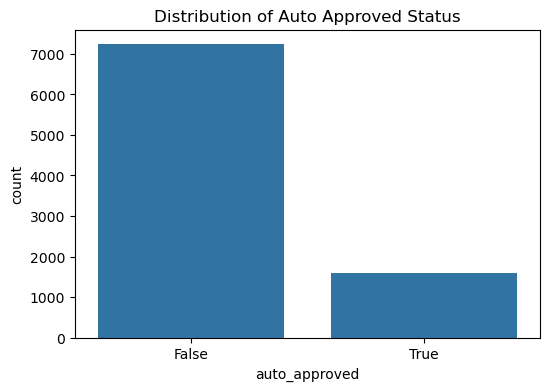

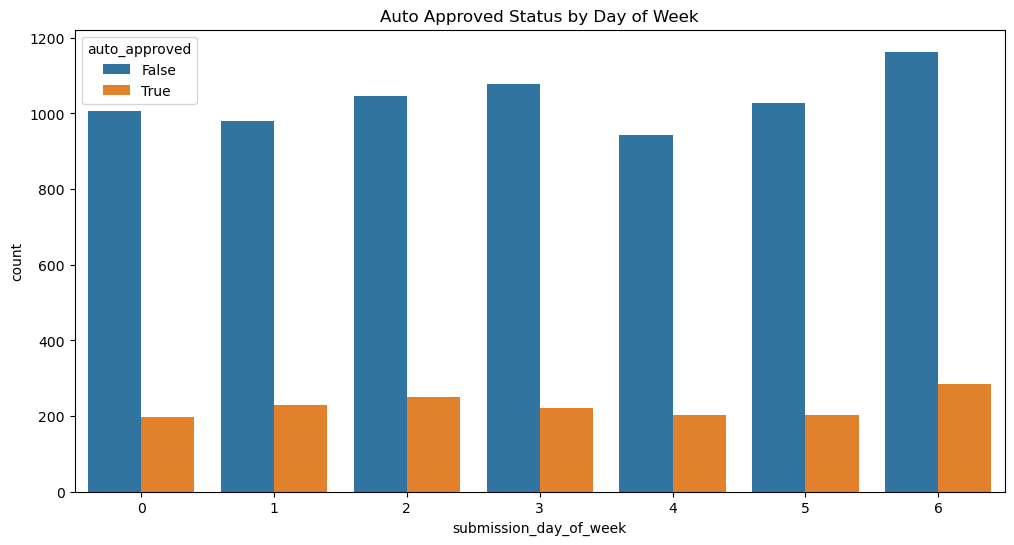

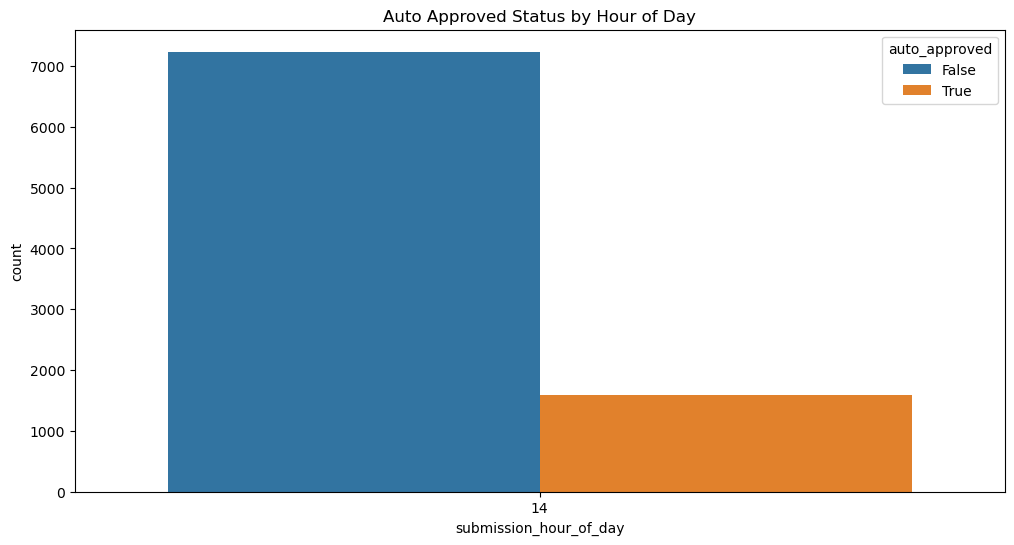

/tmp/ipykernel_1442/2418024306.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='service', palette='viridis')


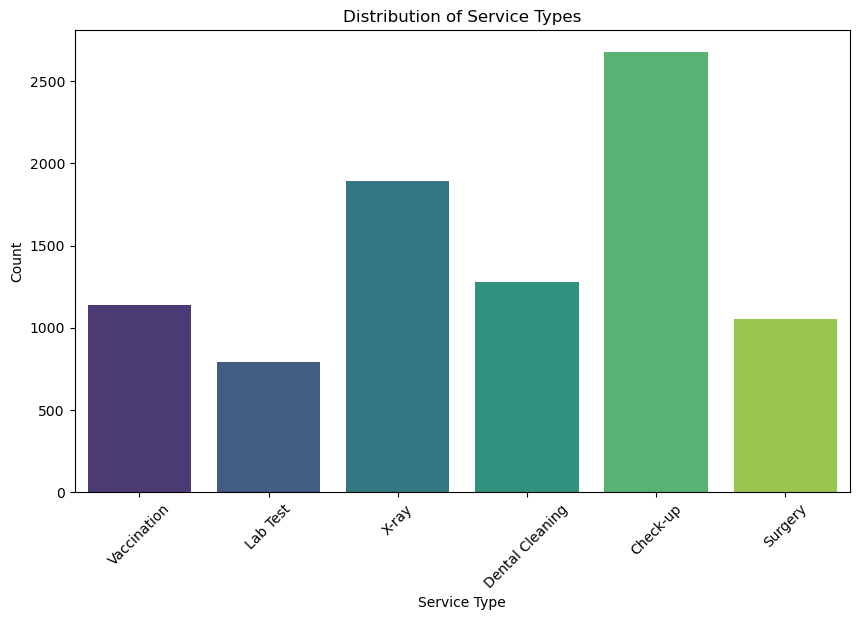

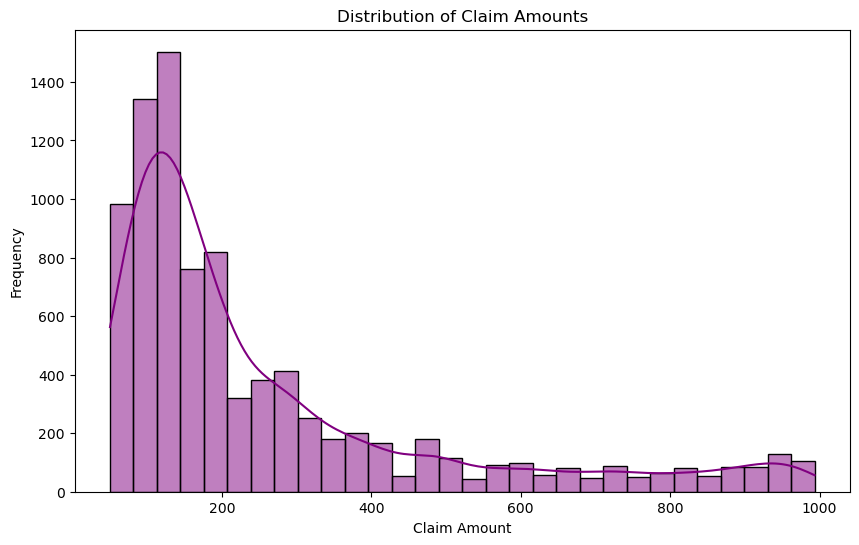

/tmp/ipykernel_1442/2418024306.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Claim Type', y='auto_approved', palette='pastel')


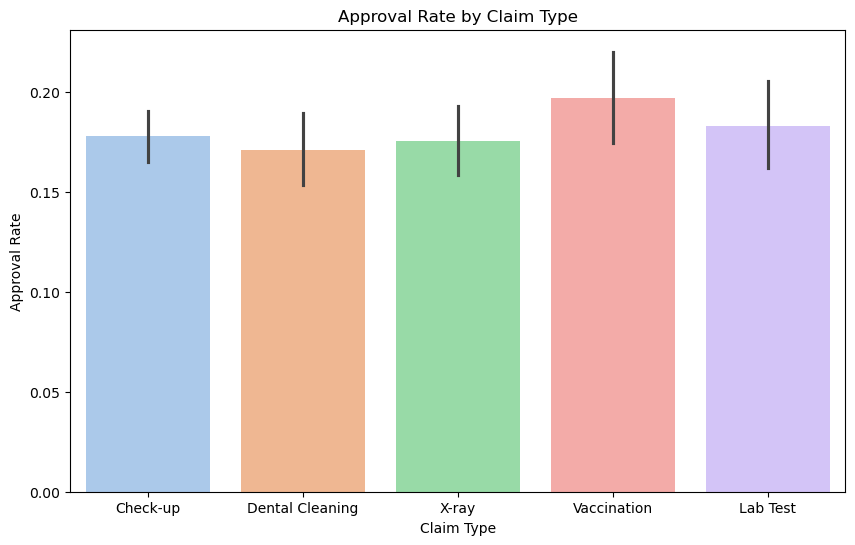

/tmp/ipykernel_1442/2418024306.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='unit', palette='coolwarm')


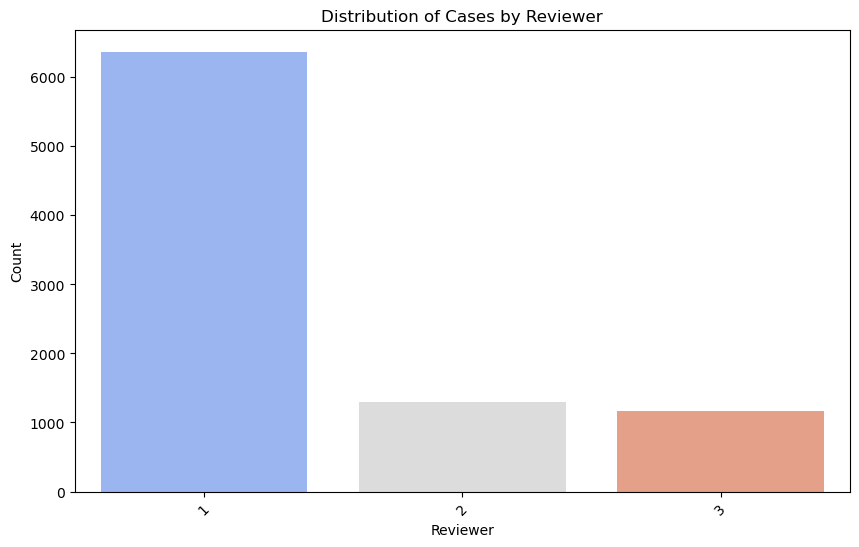

In [10]:
exploratory_data_analysis(data)

# 5. Feature Selection and Model Building

In [12]:
def model_training(X_res, y_res):
    # Feature Selection using RFECV
    selector = RFECV(RandomForestClassifier(random_state=42), step=1, cv=5, scoring='accuracy')
    selector.fit(X_res, y_res)
    X_res_selected = X_res.loc[:, selector.support_]
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_res_selected, y_res, test_size=0.3, random_state=42)
    
    # Model Training and Hyperparameter Tuning
    models = {
        'Logistic Regression': LogisticRegression(max_iter=10000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
    }
    
    param_grids = {
        'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
        'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
        'XGBoost': {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
        'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]},
        'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1]},
    }
    
    best_model = None
    best_score = 0
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Cross-validation with Grid Search for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Cross-validated score of the best model found by Grid Search
        cv_score = cross_val_score(grid_search.best_estimator_, X_res_selected, y_res, cv=5, scoring='accuracy').mean()
        print(f"Mean CV Accuracy for {model_name}: {cv_score:.4f}")
        
        # Update best model based on cross-validation score
        if cv_score > best_score:
            best_score = cv_score
            best_model = grid_search.best_estimator_

    # Stacking Ensemble Model
    print("\nTraining Stacking Model...")
    voting_model = VotingClassifier(estimators=[
        ('logistic', LogisticRegression(max_iter=10000)),
        ('random_forest', RandomForestClassifier(random_state=42)),
        ('xgboost', xgb.XGBClassifier(random_state=42))
    ], voting='soft')
    
    voting_model.fit(X_train, y_train)
    voting_cv_score = cross_val_score(voting_model, X_res_selected, y_res, cv=5, scoring='accuracy').mean()
    print(f"Mean CV Accuracy for Stacking Model: {voting_cv_score:.4f}")

    # Final Evaluation on Test Set
    y_pred = best_model.predict(X_test)
    print(f"\nBest Model: {best_model} with CV Accuracy: {best_score:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Feature Importance if XGBoost
    if isinstance(best_model, xgb.XGBClassifier):
        xgb.plot_importance(best_model, max_num_features=10)
        plt.show()

        explainer = shap.Explainer(best_model)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")
    
    # Save the model and encoders
    joblib.dump(best_model, 'best_model.joblib')
    for col, le in label_encoders.items():
        joblib.dump(le, f'label_encoder_{col}.joblib')
    print("Model and encoders saved successfully.")
    
    return best_model


Training Logistic Regression...
Mean CV Accuracy for Logistic Regression: 0.6837

Training Random Forest...
Mean CV Accuracy for Random Forest: 0.8359

Training XGBoost...
Mean CV Accuracy for XGBoost: 0.8346

Training Gradient Boosting...
Mean CV Accuracy for Gradient Boosting: 0.8400

Training AdaBoost...


/opt/conda/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Mean CV Accuracy for AdaBoost: 0.7012

Training Stacking Model...
Mean CV Accuracy for Stacking Model: 0.8277

Best Model: GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=42) with CV Accuracy: 0.8400
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2180
           1       0.90      0.89      0.89      2164

    accuracy                           0.89      4344
   macro avg       0.89      0.89      0.89      4344
weighted avg       0.89      0.89      0.89      4344

Test Set Accuracy: 0.8925


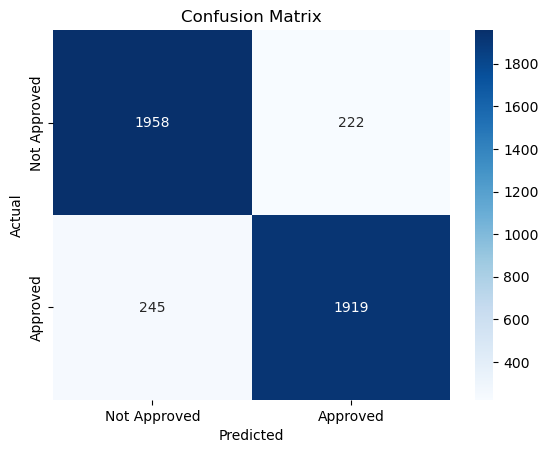

Model and encoders saved successfully.


In [13]:
# Train and evaluate models
best_model = model_training(X_res, y_res)

**Case Study Summary: Cohere Pets Prior Authorization Prediction**

This case study focuses on developing a predictive model to automate the approval process of prior authorization requests for pet medical procedures at Cohere Pets. By leveraging historical data and machine learning, this model is designed to streamline the approval workflow, reduce manual intervention, and ultimately improve efficiency and customer satisfaction.

### Project Workflow

1. **Data Loading & Preprocessing**:
   - Multiple datasets were loaded and merged on a unique identifier to create a comprehensive dataset.
   - Key features such as submission and claim timestamps were extracted from date fields to enable time-based analysis.
   - Missing values were addressed based on data types (mean for numerical features, mode for categorical), and outliers were detected and removed using the Interquartile Range (IQR) method to improve data quality.

2. **Data Cleaning & Feature Engineering**:
   - Irrelevant or redundant columns, including ID columns not relevant to predictions, were removed to reduce noise.
   - Categorical features were label-encoded, transforming them into numerical values required by machine learning algorithms.
   - The target variable, `auto_approved`, was converted into a binary format where 1 represented an approved request, and 0 represented a denied request.
   - Class imbalance was mitigated using SMOTE (Synthetic Minority Over-sampling Technique), ensuring that the model would handle both approval and denial cases effectively without bias.

3. **Feature Engineering**:
   - Key features were engineered to capture relevant information, including `service`, `provider_id`, `unit`, `authstatus`, `Claim Type`, and `Amount Paid`.
   - Additional features, such as `submission_day_of_week` and `submission_hour_of_day`, were created to capture temporal patterns in submissions, which could reveal trends impacting approval likelihood.

4. **Feature Selection**:
   - An initial feature selection process retained essential features contributing to predictive power, ensuring model performance and interpretability.
   - Selected features included `service`, `provider_id`, `unit`, `authstatus`, `Claim Type`, `Amount Paid`, `submission_day_of_week`, and `submission_hour_of_day`.

5. **Model Training & Evaluation**:
   - The dataset was split into training and testing sets, enabling model validation.
   - Various machine learning models, including logistic regression, decision trees, and random forests, were evaluated for performance.
   - Cross-validation was applied to assess model robustness and prevent overfitting.
   - Model performance was measured using metrics such as accuracy, precision, recall, and F1-score, optimizing for recall to reduce false negatives.

6. **Interpretation & Deployment**:
   - The selected model was fine-tuned to achieve the best performance for Cohere Pets’ business needs.
   - Interpretability techniques, such as feature importance analysis, were applied to explain model decisions, ensuring transparency for the medical authorization team.

### Conclusion

This predictive model is set to transform Cohere Pets’ prior authorization workflow by automating decision-making for medical procedure approvals. The model significantly reduces manual review time and improves consistency in approvals, benefiting both the operational team and clients. The final deliverables include a Jupyter notebook with the code, a 20-30 minute presentation explaining the methodology and results, and a robust model ready for deployment.